Importing required packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

LOADING DATA

In [16]:
#Loading the Labeled Anomalies dataset
labeled_anomalies = pd.read_csv('./data/labeled_anomalies.csv')
labeled_anomalies['spacecraft'] = labeled_anomalies['spacecraft'].map({'SMAP': 0, 'MSL': 1})

In [17]:
#Function to load and label data
def load_and_label_data(data_dir, labeled_anomalies):
    smap_data, msl_data = [], []
    smap_labels, msl_labels = [], []
    for filename in os.listdir(data_dir):
        if filename.endswith('.npy'):
            chan_id = filename.replace('.npy', '').strip()

            match = labeled_anomalies[labeled_anomalies['chan_id'] == chan_id]
            if not match.empty:
                spacecraft_label = match['spacecraft'].values[0]
                data = np.load(os.path.join(data_dir, filename))
                df = pd.DataFrame(data)

                # Adding labels
                anomaly_sequences = ast.literal_eval(match['anomaly_sequences'].values[0])
                anomaly_labels = np.zeros(len(df))
                columns = data.shape[1]

                for anomaly in anomaly_sequences:
                    start = int(int(anomaly[0]) / columns)
                    end = int(int(anomaly[1]) / columns)
                    anomaly_labels[start:end] = 1

                anomaly_labels = pd.DataFrame(anomaly_labels)

                if spacecraft_label == 0:
                    smap_data.append(df)
                    smap_labels.append(anomaly_labels)
                elif spacecraft_label == 1:
                    msl_data.append(df)
                    msl_labels.append(anomaly_labels)

    # Stack all loaded data
    smap_data = pd.DataFrame(np.vstack(smap_data)) if smap_data else pd.DataFrame()
    msl_data = pd.DataFrame(np.vstack(msl_data)) if msl_data else pd.DataFrame()
    smap_labels = pd.DataFrame(np.vstack(smap_labels)) if smap_labels else pd.DataFrame()
    msl_labels = pd.DataFrame(np.vstack(msl_labels)) if msl_labels else pd.DataFrame()

    return smap_data, smap_labels, msl_data, msl_labels


In [18]:
#Assign data to MSL/SMAP
train_dir = './data/train/'
test_dir = './data/test/'
smap_data_train, smap_labels_train, msl_data_train, msl_labels_train = load_and_label_data(train_dir, labeled_anomalies)
smap_data_test, smap_labels_test, msl_data_test, msl_labels_test = load_and_label_data(test_dir, labeled_anomalies)


PRE-PROCESSING

In [19]:
def remove_low_info_columns(data_train, data_test, dataset_name, threshold_ratio=0.01):
    non_zero_counts = (data_train != 0).sum()
    threshold = threshold_ratio * len(data_train)

    # Exclude 0th column from plotting
    plot_counts = non_zero_counts.drop(index=0)
    colors = ['red' if val < threshold else 'blue' for val in plot_counts]

    # Plotting
    plt.figure(figsize=(12, 6))
    bars = plt.bar(plot_counts.index, plot_counts.values, color=colors)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 5, f'{int(height)}',
                 ha='center', va='bottom', fontsize=8, rotation=90)

    plt.axhline(y=threshold, color='gray', linestyle='--', label=f'{int(threshold_ratio * 100)}% Threshold')
    plt.title(f'Non-Zero Value Counts per Channel in {dataset_name} Data Train')
    plt.xlabel('Channel Index')
    plt.ylabel('Non-Zero Value Count')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Removing low-information columns (including column 0 if applicable)
    low_info_cols = non_zero_counts[non_zero_counts < threshold].index
    data_train_filtered = data_train.drop(columns=low_info_cols)
    data_test_filtered = data_test.drop(columns=low_info_cols)

    print(f"Removed columns in {dataset_name}:", list(low_info_cols))
    print(f"{dataset_name} Train shape:", data_train_filtered.shape)
    print(f"{dataset_name} Test shape:", data_test_filtered.shape)

    return data_train_filtered, data_test_filtered


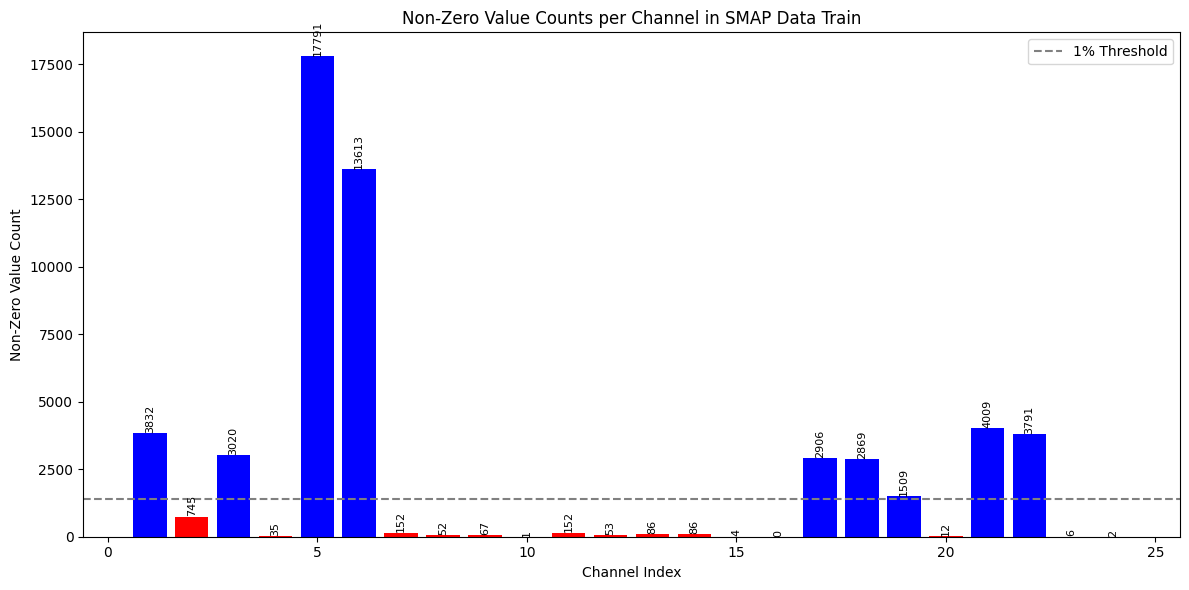

Removed columns in SMAP: [2, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 23, 24]
SMAP Train shape: (138004, 10)
SMAP Test shape: (435826, 10)


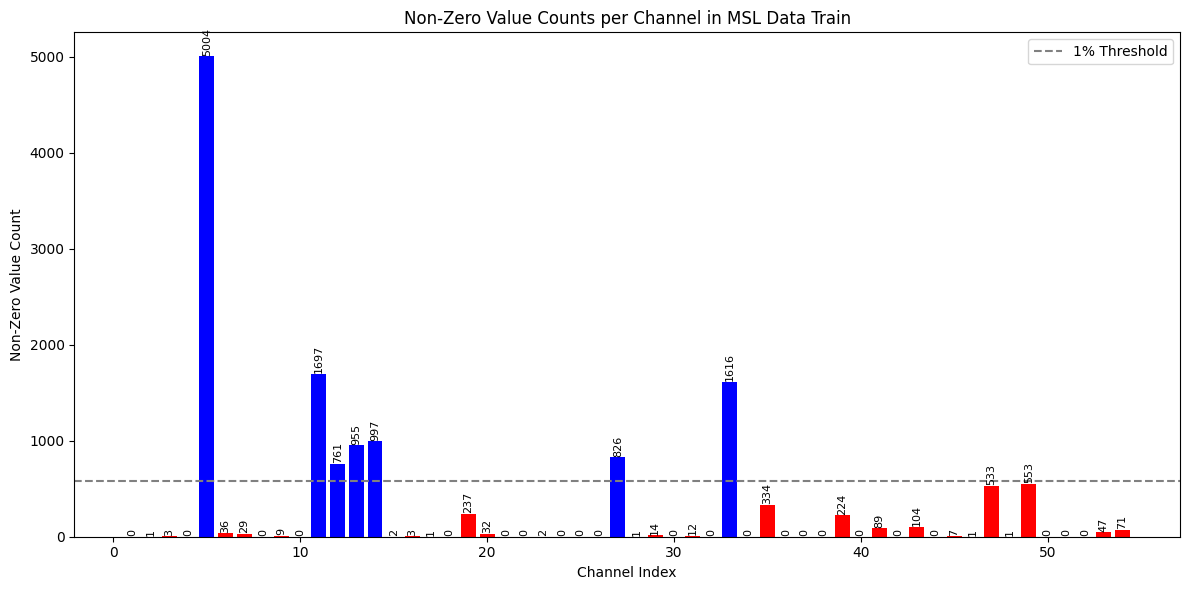

Removed columns in MSL: [1, 2, 3, 4, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
MSL Train shape: (58317, 8)
MSL Test shape: (73729, 8)


In [20]:
#Preprocessing the data
smap_data_train, smap_data_test = remove_low_info_columns(smap_data_train, smap_data_test, "SMAP")
msl_data_train, msl_data_test = remove_low_info_columns(msl_data_train, msl_data_test, "MSL")


VISUALIZING THE DATASET

In [7]:
import matplotlib.pyplot as plt

def plot_columns_separately(data, dataset_name='Dataset'):
    num_cols = data.shape[1]

    plt.figure(figsize=(16, 2.5 * num_cols))  # Adjust height based on number of plots
    for i in range(num_cols):
        plt.subplot(num_cols, 1, i + 1)
        plt.plot(data.iloc[:, i], color='green')
        plt.title(f'{dataset_name} - Channel {i}', fontsize=10)
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.tight_layout()

    plt.suptitle(f'{dataset_name} Data - All Channels', fontsize=14, y=1.02)
    plt.subplots_adjust(hspace=0.6)  # Add more vertical space between subplots
    plt.show()


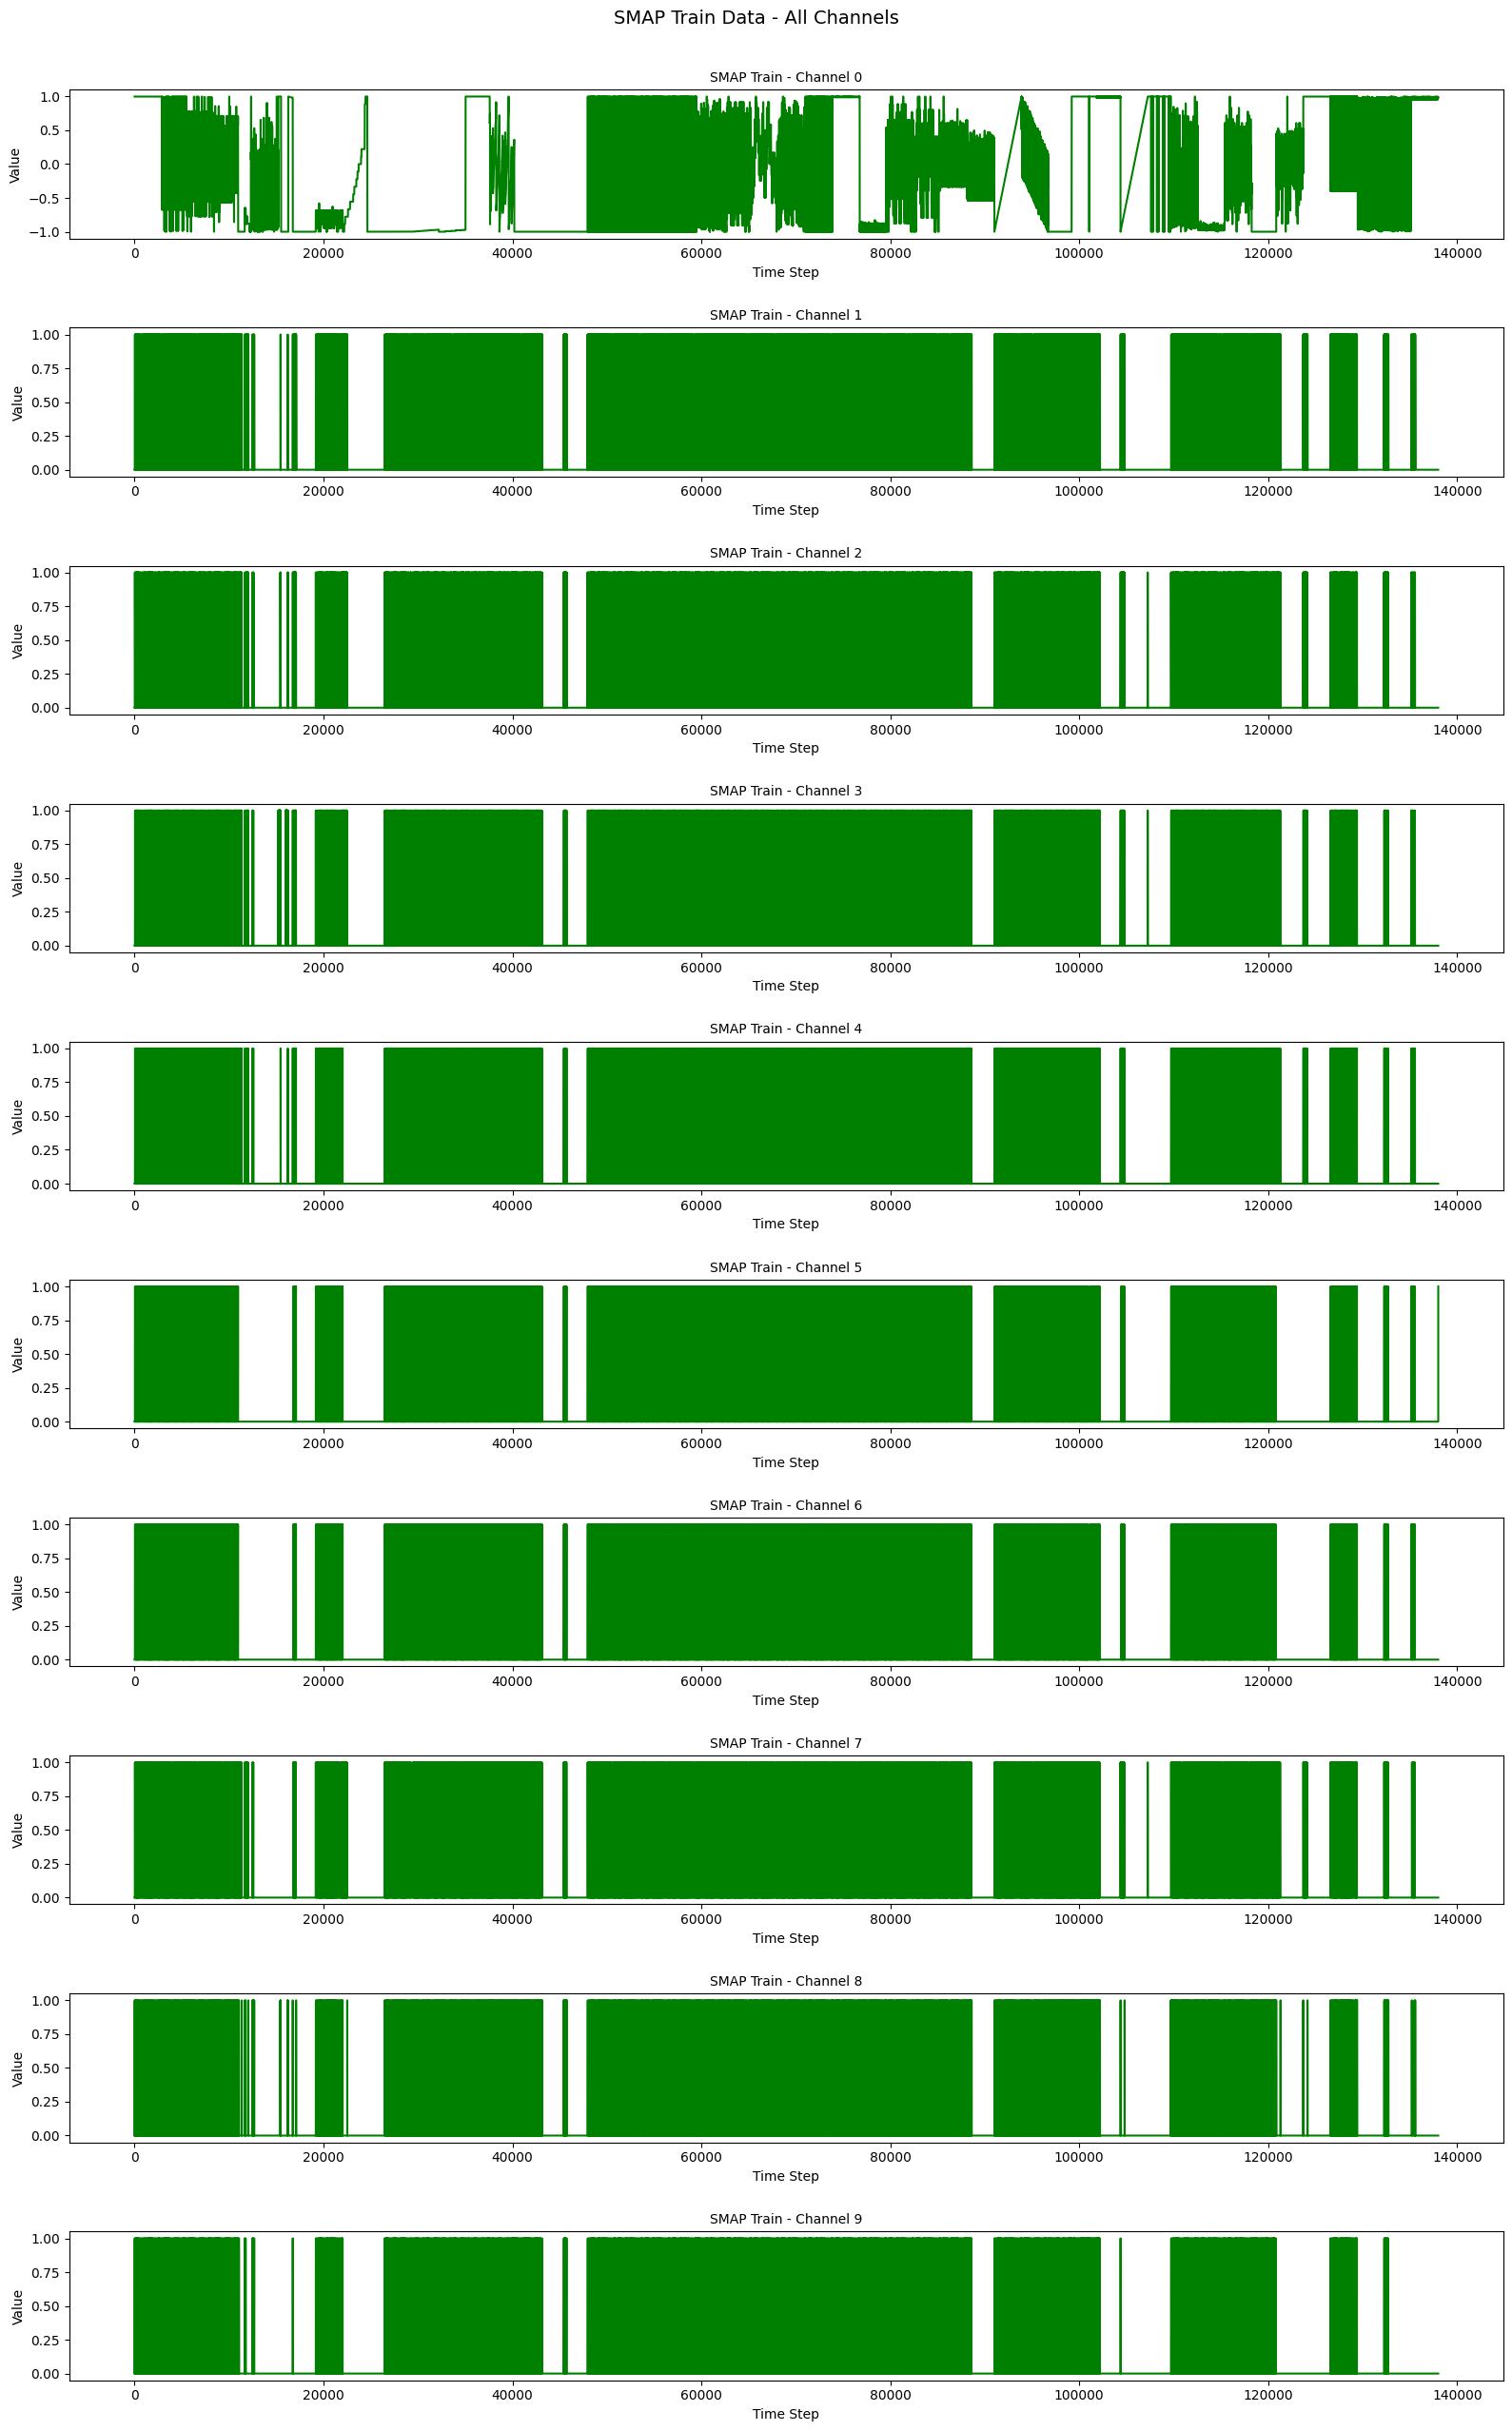

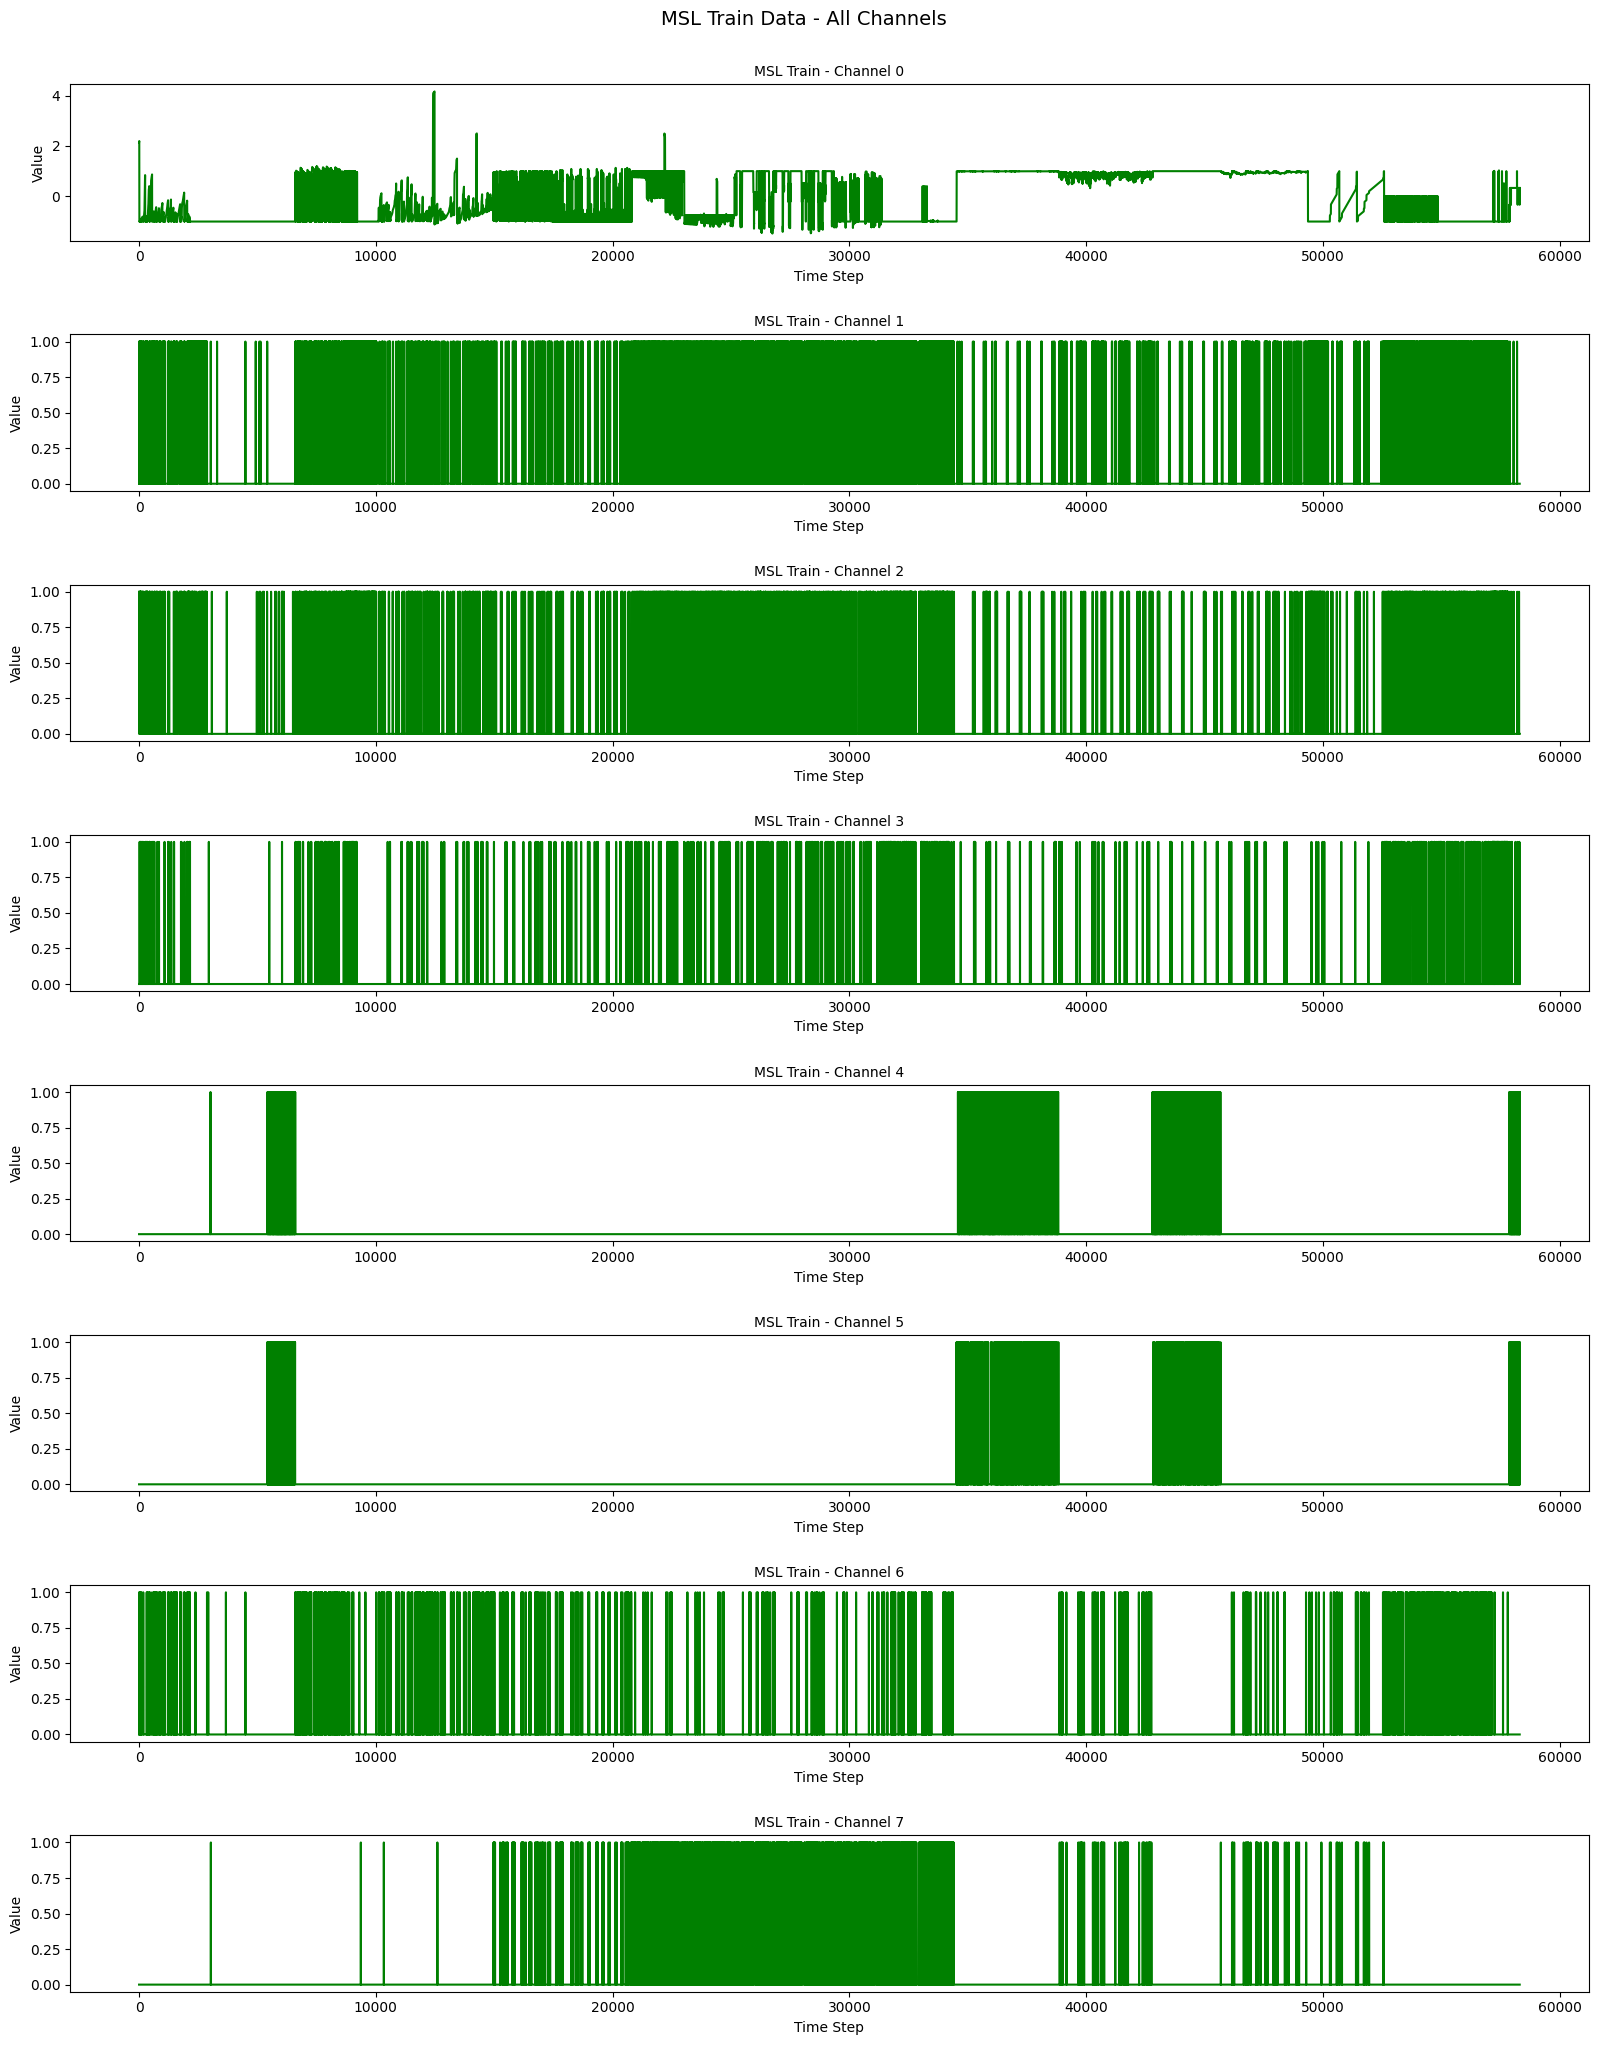

In [8]:
plot_columns_separately(smap_data_train, 'SMAP Train')
plot_columns_separately(msl_data_train, 'MSL Train')


MULTI LAYER PERCEPTRON MODEL

In [9]:
# Define MLP model class
class BaselineMLP(nn.Module):
    def __init__(self, input_dim):
        super(BaselineMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x).squeeze()

TRANSFORMER MODEL

In [10]:
# Define a simple Transformer-based model for anomaly detection
class TransformerModel(nn.Module):
    def __init__(self, input_dim, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x).squeeze()

TRAINING THE MODEL

In [11]:
def train_model(model, train_loader, device, epochs=100, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

METRIC EVALUATION

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            if output.dim() == 0:
                output = output.unsqueeze(0)
            preds = (output > 0.5).float()
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(y.view(-1).cpu().numpy())
    return all_preds, all_labels


def print_metrics(preds, labels, name="Model"):
    acc = accuracy_score(labels, preds)
    print(f"\n{name} Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    return acc

def plot_loss_curve(losses, label="Loss Curve"):
    plt.figure(figsize=(8, 4))
    plt.plot(losses, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss - {label}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RUNNING THE MODEL

In [14]:
def run_all_models(dataset_name, data_train, labels_train, data_test, labels_test):
    # Preparing the data
    print(f"\n==================== {dataset_name.upper()} DATA ====================")
    
    train_ds = TensorDataset(torch.tensor(data_train.values, dtype=torch.float32),
                             torch.tensor(labels_train.values, dtype=torch.float32).squeeze())
    test_ds = TensorDataset(torch.tensor(data_test.values, dtype=torch.float32),
                            torch.tensor(labels_test.values, dtype=torch.float32).squeeze())
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
    input_dim = data_train.shape[1]

    # Train MLP
    print("\n--- Training MLP ---")
    mlp_model = BaselineMLP(input_dim)
    mlp_losses = train_model(mlp_model, train_loader, device)
    plot_loss_curve(mlp_losses, f"MLP on {dataset_name}")
    mlp_preds, mlp_labels = evaluate(mlp_model, test_loader, device)
    print_metrics(mlp_preds, mlp_labels, name=f"MLP {dataset_name}")

    # Train Transformer
    print("\n--- Training Transformer ---")
    transformer_model = TransformerModel(input_dim)
    trans_losses = train_model(transformer_model, train_loader, device)
    plot_loss_curve(trans_losses, f"Transformer on {dataset_name}")
    trans_preds, trans_labels = evaluate(transformer_model, test_loader, device)
    print_metrics(trans_preds, trans_labels, name=f"Transformer {dataset_name}")


RUNNING THE MODELS


==================== SMAP DATA ====================

--- Training MLP ---
Epoch 1/100, Loss: 0.0923
Epoch 2/100, Loss: 0.0818
Epoch 3/100, Loss: 0.0817
Epoch 4/100, Loss: 0.0818
Epoch 5/100, Loss: 0.0817
Epoch 6/100, Loss: 0.0818
Epoch 7/100, Loss: 0.0817
Epoch 8/100, Loss: 0.0816
Epoch 9/100, Loss: 0.0816
Epoch 10/100, Loss: 0.0818
Epoch 11/100, Loss: 0.0817
Epoch 12/100, Loss: 0.0816
Epoch 13/100, Loss: 0.0816
Epoch 14/100, Loss: 0.0816
Epoch 15/100, Loss: 0.0816
Epoch 16/100, Loss: 0.0815
Epoch 17/100, Loss: 0.0815
Epoch 18/100, Loss: 0.0816
Epoch 19/100, Loss: 0.0816
Epoch 20/100, Loss: 0.0816
Epoch 21/100, Loss: 0.0816
Epoch 22/100, Loss: 0.0816
Epoch 23/100, Loss: 0.0815
Epoch 24/100, Loss: 0.0814
Epoch 25/100, Loss: 0.0816
Epoch 26/100, Loss: 0.0815
Epoch 27/100, Loss: 0.0814
Epoch 28/100, Loss: 0.0814
Epoch 29/100, Loss: 0.0814
Epoch 30/100, Loss: 0.0815
Epoch 31/100, Loss: 0.0814
Epoch 32/100, Loss: 0.0814
Epoch 33/100, Loss: 0.0814
Epoch 34/100, Loss: 0.0814
Epoch 35/100, Lo

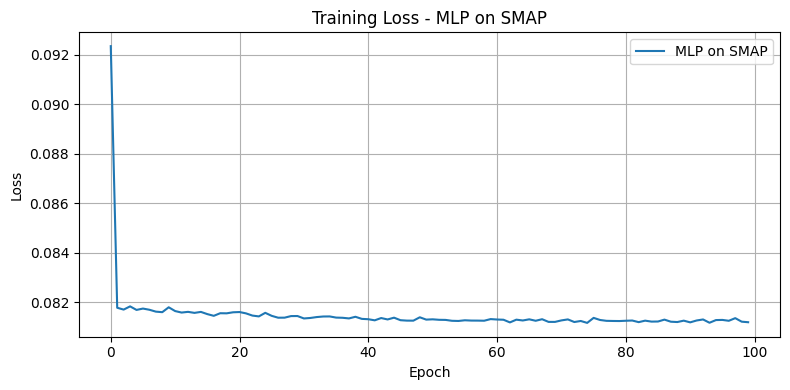


MLP SMAP Evaluation:
Accuracy:  0.9949

--- Training Transformer ---
Epoch 1/100, Loss: 0.0837
Epoch 2/100, Loss: 0.0828
Epoch 3/100, Loss: 0.0823
Epoch 4/100, Loss: 0.0822
Epoch 5/100, Loss: 0.0823
Epoch 6/100, Loss: 0.0829
Epoch 7/100, Loss: 0.0828
Epoch 8/100, Loss: 0.0824
Epoch 9/100, Loss: 0.0824
Epoch 10/100, Loss: 0.0824
Epoch 11/100, Loss: 0.0823
Epoch 12/100, Loss: 0.0827
Epoch 13/100, Loss: 0.0824
Epoch 14/100, Loss: 0.0823
Epoch 15/100, Loss: 0.0822
Epoch 16/100, Loss: 0.0821
Epoch 17/100, Loss: 0.0823
Epoch 18/100, Loss: 0.0823
Epoch 19/100, Loss: 0.0822
Epoch 20/100, Loss: 0.0823
Epoch 21/100, Loss: 0.0823
Epoch 22/100, Loss: 0.0822
Epoch 23/100, Loss: 0.0821
Epoch 24/100, Loss: 0.0820
Epoch 25/100, Loss: 0.0822
Epoch 26/100, Loss: 0.0822
Epoch 27/100, Loss: 0.0820
Epoch 28/100, Loss: 0.0820
Epoch 29/100, Loss: 0.0826
Epoch 30/100, Loss: 0.0825
Epoch 31/100, Loss: 0.0823
Epoch 32/100, Loss: 0.0819
Epoch 33/100, Loss: 0.0821
Epoch 34/100, Loss: 0.0821
Epoch 35/100, Loss: 0

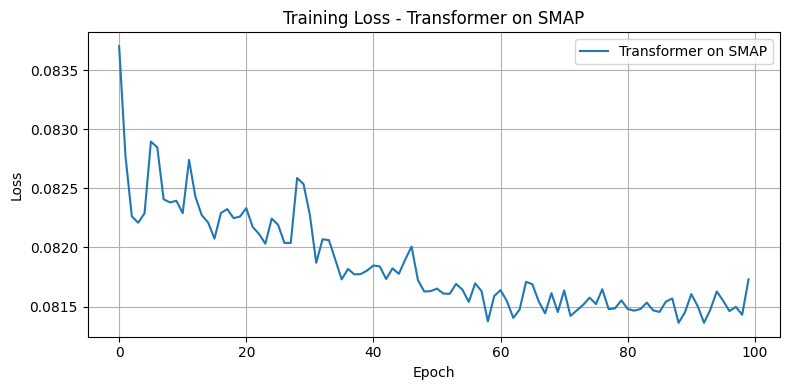

c:\Users\Saathvika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Transformer SMAP Evaluation:
Accuracy:  0.9949

==================== MSL DATA ====================

--- Training MLP ---
Epoch 1/100, Loss: 0.0503
Epoch 2/100, Loss: 0.0173
Epoch 3/100, Loss: 0.0170
Epoch 4/100, Loss: 0.0172
Epoch 5/100, Loss: 0.0167
Epoch 6/100, Loss: 0.0166
Epoch 7/100, Loss: 0.0167
Epoch 8/100, Loss: 0.0165
Epoch 9/100, Loss: 0.0166
Epoch 10/100, Loss: 0.0166
Epoch 11/100, Loss: 0.0165
Epoch 12/100, Loss: 0.0165
Epoch 13/100, Loss: 0.0166
Epoch 14/100, Loss: 0.0165
Epoch 15/100, Loss: 0.0165
Epoch 16/100, Loss: 0.0165
Epoch 17/100, Loss: 0.0165
Epoch 18/100, Loss: 0.0165
Epoch 19/100, Loss: 0.0165
Epoch 20/100, Loss: 0.0165
Epoch 21/100, Loss: 0.0165
Epoch 22/100, Loss: 0.0166
Epoch 23/100, Loss: 0.0165
Epoch 24/100, Loss: 0.0165
Epoch 25/100, Loss: 0.0164
Epoch 26/100, Loss: 0.0165
Epoch 27/100, Loss: 0.0165
Epoch 28/100, Loss: 0.0164
Epoch 29/100, Loss: 0.0165
Epoch 30/100, Loss: 0.0165
Epoch 31/100, Loss: 0.0165
Epoch 32/100, Loss: 0.0165
Epoch 33/100, Loss: 0.0

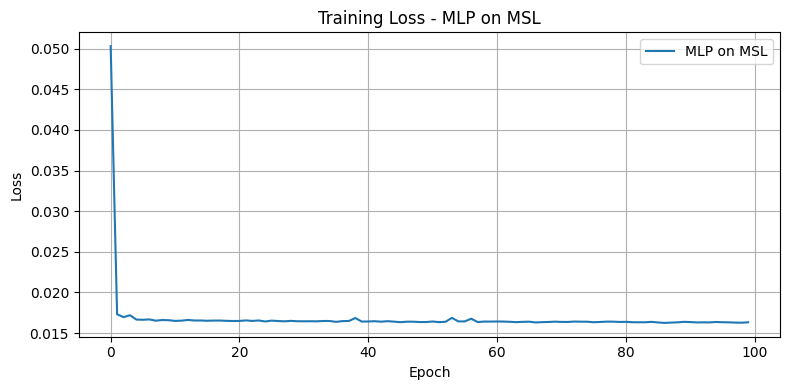

c:\Users\Saathvika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MLP MSL Evaluation:
Accuracy:  0.9981

--- Training Transformer ---
Epoch 1/100, Loss: 0.0195
Epoch 2/100, Loss: 0.0167
Epoch 3/100, Loss: 0.0168
Epoch 4/100, Loss: 0.0168
Epoch 5/100, Loss: 0.0166
Epoch 6/100, Loss: 0.0169
Epoch 7/100, Loss: 0.0166
Epoch 8/100, Loss: 0.0168
Epoch 9/100, Loss: 0.0169
Epoch 10/100, Loss: 0.0169
Epoch 11/100, Loss: 0.0169
Epoch 12/100, Loss: 0.0169
Epoch 13/100, Loss: 0.0169
Epoch 14/100, Loss: 0.0168
Epoch 15/100, Loss: 0.0168
Epoch 16/100, Loss: 0.0168
Epoch 17/100, Loss: 0.0168
Epoch 18/100, Loss: 0.0168
Epoch 19/100, Loss: 0.0167
Epoch 20/100, Loss: 0.0168
Epoch 21/100, Loss: 0.0168
Epoch 22/100, Loss: 0.0167
Epoch 23/100, Loss: 0.0168
Epoch 24/100, Loss: 0.0168
Epoch 25/100, Loss: 0.0168
Epoch 26/100, Loss: 0.0168
Epoch 27/100, Loss: 0.0172
Epoch 28/100, Loss: 0.0167
Epoch 29/100, Loss: 0.0168
Epoch 30/100, Loss: 0.0168
Epoch 31/100, Loss: 0.0167
Epoch 32/100, Loss: 0.0168
Epoch 33/100, Loss: 0.0167
Epoch 34/100, Loss: 0.0168
Epoch 35/100, Loss: 0.

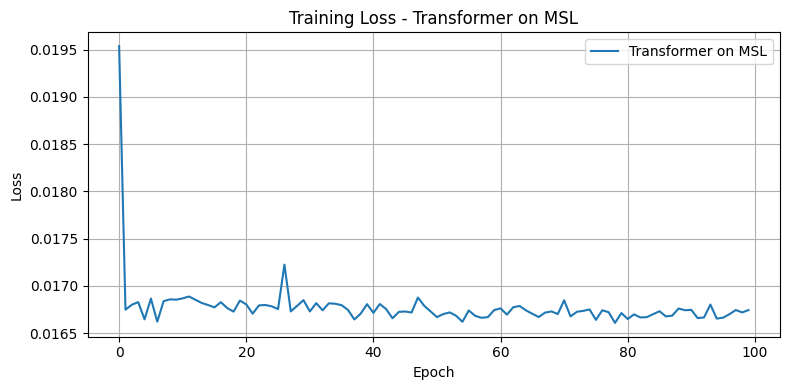

c:\Users\Saathvika\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Transformer MSL Evaluation:
Accuracy:  0.9981


In [15]:
run_all_models("SMAP", smap_data_train, smap_labels_train, smap_data_test, smap_labels_test)
run_all_models("MSL", msl_data_train, msl_labels_train, msl_data_test, msl_labels_test)
